# Gender and Age detection

dataset :- https://www.kaggle.com/datasets/jangedoo/utkface-new

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
image_path

['23_1_2_20170116172910708.jpg.chip.jpg',
 '28_0_1_20170113150719161.jpg.chip.jpg',
 '26_1_0_20170116234741431.jpg.chip.jpg',
 '37_0_3_20170119202516470.jpg.chip.jpg',
 '60_0_0_20170109013457906.jpg.chip.jpg',
 '2_0_2_20161219162359990.jpg.chip.jpg',
 '8_0_0_20170110222913531.jpg.chip.jpg',
 '34_1_4_20170113011428472.jpg.chip.jpg',
 '48_1_0_20170109220544479.jpg.chip.jpg',
 '54_0_0_20170113210319475.jpg.chip.jpg',
 '63_0_0_20170113210318902.jpg.chip.jpg',
 '35_1_1_20170113001239705.jpg.chip.jpg',
 '9_1_0_20170109202813775.jpg.chip.jpg',
 '29_1_1_20170116171830504.jpg.chip.jpg',
 '56_1_0_20170103180406295.jpg.chip.jpg',
 '35_0_3_20170119201257884.jpg.chip.jpg',
 '5_0_0_20170109193414770.jpg.chip.jpg',
 '1_0_2_20161219203256078.jpg.chip.jpg',
 '14_0_3_20170104225721488.jpg.chip.jpg',
 '27_0_0_20170113210319553.jpg.chip.jpg',
 '61_1_0_20170117192059259.jpg.chip.jpg',
 '27_0_0_20170117175751139.jpg.chip.jpg',
 '34_0_4_20170105161411273.jpg.chip.jpg',
 '35_0_0_20170117204518056.jpg.chip.jpg

# Transformatio to Structured data 

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [9]:
df.head()

,image,age,gender
0,23_1_2_20170116172910708.jpg.chip.jpg,23,1
1,28_0_1_20170113150719161.jpg.chip.jpg,28,0
2,26_1_0_20170116234741431.jpg.chip.jpg,26,1
3,37_0_3_20170119202516470.jpg.chip.jpg,37,0
4,60_0_0_20170109013457906.jpg.chip.jpg,60,0


In [10]:
gender_dict = {0:"Male",1:"Female"}

In [11]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [12]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


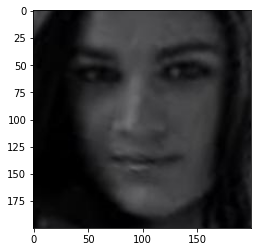

In [14]:
img = Image.open("UTKFace/"+df.image[2])
plt.imshow(img)

C:\Users\anees\AppData\Local\Temp\ipykernel_7296\2409177837.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<AxesSubplot:xlabel='age', ylabel='Density'>

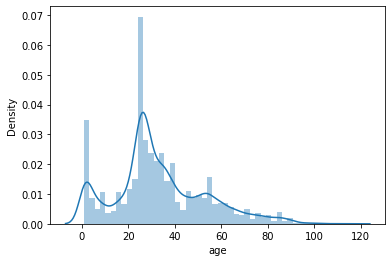

In [15]:
sns.distplot(df.age)

# Plotting Images

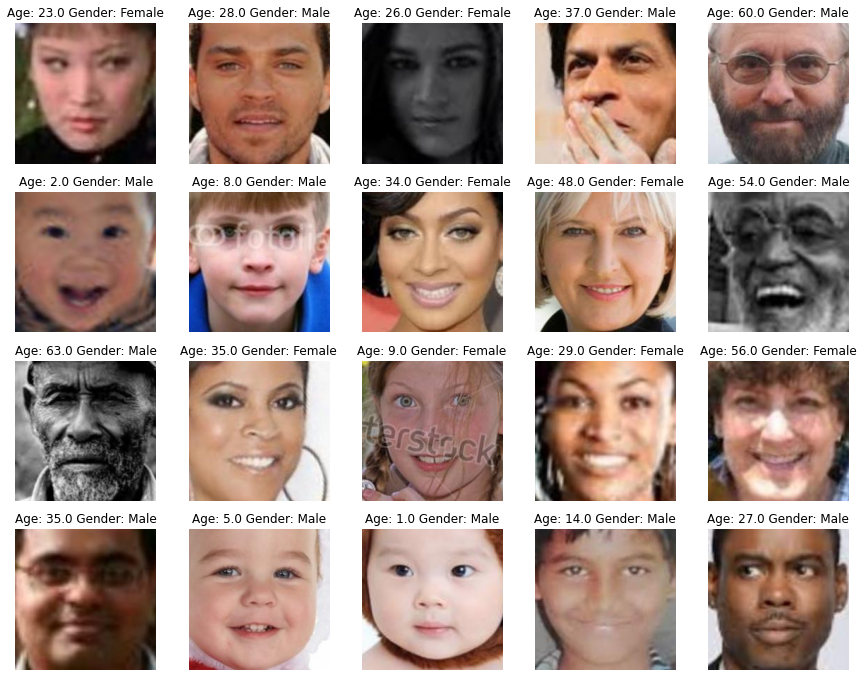

In [16]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [17]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [18]:
train.head()

,image,age,gender
18199,78_1_1_20170113011857601.jpg.chip.jpg,78.0,1
19557,24_0_2_20170103223924087.jpg.chip.jpg,24.0,0
20132,34_1_3_20170119152405425.jpg.chip.jpg,34.0,1
11849,46_0_3_20170119183135878.jpg.chip.jpg,46.0,0
2100,30_0_2_20170116174814595.jpg.chip.jpg,30.0,0


# Extracting Features

In [19]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

c:\Users\anees\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\anees\AppData\Local\Temp\ipykernel_7296\342092079.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [20]:
x_train.shape

(3556, 128, 128, 1)

# Normalizing data

In [21]:
x_train = x_train/255

In [22]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [23]:
input_size = (128,128,1)

# Creating model

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but I have implemented CNN with little Skip connections (shortcut). 

In [24]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [25]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training the model

In [28]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 106s 331ms/step - loss: 10.3066 - gender_output_loss: 0.3611 - age_output_loss: 9.9455 - gender_output_accuracy: 0.8328 - age_output_accuracy: 0.0497 - val_loss: 9.1580 - val_gender_output_loss: 0.3900 - val_age_output_loss: 8.7680 - val_gender_output_accuracy: 0.8399 - val_age_output_accuracy: 0.0534
Epoch 2/20
320/320 [==============================] - 104s 324ms/step - loss: 9.6708 - gender_output_loss: 0.3315 - age_output_loss: 9.3392 - gender_output_accuracy: 0.8528 - age_output_accuracy: 0.0497 - val_loss: 15.1721 - val_gender_output_loss: 0.5351 - val_age_output_loss: 14.6370 - val_gender_output_accuracy: 0.7500 - val_age_output_accuracy: 0.0534
Epoch 3/20
320/320 [==============================] - 97s 303ms/step - loss: 9.4236 - gender_output_loss: 0.3080 - age_output_loss: 9.1157 - gender_output_accuracy: 0.8637 - age_output_accuracy: 0.0497 - val_loss: 9.9504 - val_gender_output_loss: 0.3443 - val_age_output_loss: 9.6062 -

# Visualizing loss

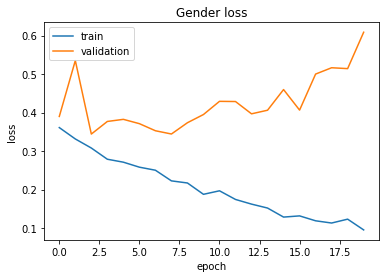

In [29]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

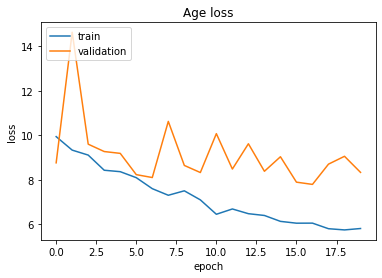

In [30]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Male  Age =  35.0
1/1 [==============================] - 0s 218ms/step
Prediction: Gender =  Male  Age =  35


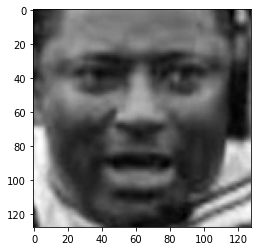

In [31]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Female  Age =  35.0
1/1 [==============================] - 0s 80ms/step
Prediction: Gender =  Female  Age =  33


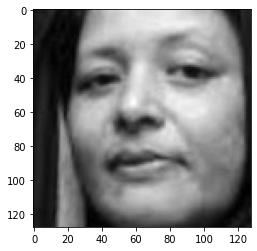

In [32]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')